# CS 363M Machine Learning Project

## Authors
- Hudson Gould (HAG929)
- Cristian Cantu (cjc5844)
- Diego Costa (dc48222)
- Dylan Dang (dad4364)

## Background



In this project, we want to predict wether or not a given baseball pitch will be a home run or not. This is an interesting problem because it could be used to better predict the outcomes of baseball games in advance (at least in terms of number of homeruns). Alternatively, one can calculate the probability of a given pitch being a home run *during* the pitch itself (though the outcome will be evident seconds after).

To do this, we are using data from the UT Baseball 2024 Season. Our dataset contains data from every single pitch during UT home games, taken from a TrackMan brand detection machine which tracks and records 3D characteristic of a baseball in motion.

We want to use this data to predict whether a given pitch will be a home run or not. We will use information such as the pitch velocities, runs scored, and other pitch information to predict this. This ML problem is especially interesting, as it suffers from a massive imbalance of classes - far more of the pitches are NOT homeruns, compared to those that are. (Reminiscent of the "predicting credit card fraud" problem). This means that our data will have to be carefully pruned and our modeling techniques must be jucicious to avoid a too-high false negative rate.



## Data Preparation

### Import packages

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
import sklearn as sk
%matplotlib inline

### Data Cleaning

##### Print the head of the data as a cursory look

In [65]:
data = pd.read_csv('data.csv')

#Print the head of the data
print(data.head())

print(data.shape)

                          game_id        Date     Time  PitchNo  Inning  \
0  20240220-HighPointUniversity-1  2024-02-20  60314.0       82       3   
1  20240220-HighPointUniversity-1  2024-02-20  63576.0      185       6   
2  20240220-HighPointUniversity-1  2024-02-20  66446.0      269       8   
3  20240220-HighPointUniversity-1  2024-02-20  64809.0      216       6   
4  20240220-HighPointUniversity-1  2024-02-20  67985.0      308       9   

  inning_half  PAofInning  PitchofPA           Pitcher   PitcherId  \
0         Top           4          2  Olsovsky, Dalton  1000251274   
1         Top           2          3     Glover, Lucas  1000138461   
2         Top           3          1      Carter, Noah  1000108939   
3      Bottom           6          1     Welch, Collin  1000192105   
4      Bottom           4          3       Lewis, Zach  1000127413   

  PitcherThrows PitcherTeam                Batter    BatterId BatterSide  \
0             R     HIG_PAN        Quintero, Adam  1

One notable feature of this data is the enourmous amount of rows - 1.5 Million! Looking at the first column "game_id", we in fact see that multiple other schools are represented in this dataset, since we see names of schools that are not Texas or it's opponent on a given day (for example, the head of this data shows a game from High Point University v Not Texas). 

For this reason, an easy first step is to remove all the rows not containing "Texas" in the first column, to give us a pruned dataset of ONLY Texas home games. We choose to ignore the Away games, as garnering insights to get a better home field advantage is better than trying to analyze our performance at 6 different other school's fields.

In [66]:
texas_data = data[data['game_id'].str.contains("Texas", na=False)]

texas_data.to_csv("texas_data.csv", index=False)

Now that we have our texas_data.csv, we can proceed with our analysis from here!

In [67]:
texas_data = pd.read_csv("texas_data.csv")

print(texas_data.head())

print("Shape of the data: ", end="")
print(texas_data.shape)

num_rows = texas_data.shape[0]

#Figure out how many games this represents
num_games = texas_data['game_id'].nunique()
print("This data represents "+str(num_games)+" games")
print("This means there were an average "+str(num_rows/num_games)+" pitches per game")

            game_id        Date     Time  PitchNo  Inning inning_half  \
0  20240220-Texas-1  2024-02-20  78782.0      357       9         Top   
1  20240220-Texas-1  2024-02-20  72532.0      158       5         Top   
2  20240220-Texas-1  2024-02-20  75554.0      252       6      Bottom   
3  20240220-Texas-1  2024-02-20  73889.0      197       5      Bottom   
4  20240220-Texas-1  2024-02-20  76475.0      281       7      Bottom   

   PAofInning  PitchofPA           Pitcher   PitcherId PitcherThrows  \
0           3          3      O'Hara, Cade  1000192590             R   
1           1          2  Hamilton, Hudson      815123             R   
2           7          3   Gilley, Brayden  1000165200             R   
3          10          3   Gilley, Brayden  1000165200             R   
4           2          6      Wilson, Dave  1000306108             R   

  PitcherTeam              Batter  BatterId BatterSide BatterTeam  \
0     TEX_LON        LaRue, Dylan    804659          L    H

After reducing our dataset to only the Texas home games, our dataset has a much more manageable 10230 rows. 

Now we want to take a more in-depth look at all of our features and use both logic and analytical methods to identify features which are not useful and then remove them as part of our feature engineering step. For this purpose, it is crucially important to understand what exactly the 77 given features are exactly.

Here are the features and their meanings: (taken from the TrackMan website)

<details>
<summary>Features</summary>

**Game Information**
- **game_id**: Game ID  
- **Date**: Date of the game  
- **Time**: Time of the pitch  
- **Inning**: Inning of the game  
- **inning_half**: Top or Bottom of the inning  
- **PAofInning**: Plate appearance of the inning  
- **PitchofPA**: Pitch number within the plate appearance  

**Pitcher Information**
- **Pitcher**: Name of the pitcher  
- **PitcherId**: Unique identifier for the pitcher  
- **PitcherThrows**: Pitcher's throwing hand (e.g., right or left)  
- **PitcherTeam**: Team of the pitcher  

**Batter Information**
- **Batter**: Name of the batter  
- **BatterId**: Unique identifier for the batter  
- **BatterSide**: Batter's stance (e.g., right or left)  
- **BatterTeam**: Team of the batter  

**Catcher Information**
- **catcher**: Name of the catcher  
- **catcher_id**: Unique identifier for the catcher  
- **catcher_team**: Team of the catcher  

**Pitch Call and Results**
- **PitchCall**: Umpire call for the pitch (e.g., ball, strike)  
- **PlayResult**: Outcome of the play (e.g., single, out, home run)  
- **KorBB**: Strikeout or base on balls indicator  
- **OutsOnPlay**: Number of outs resulting from the play  
- **RunsScored**: Runs scored on the play  

**Game State**
- **Balls**: Count of balls in the at-bat  
- **Strikes**: Count of strikes in the at-bat  
- **Outs**: Number of outs in the inning  

**Pitch Information**
- **TaggedPitchType**: Categorized pitch type (e.g., fastball, curveball)  
- **RelSpeed**: Release speed of the pitch  
- **SpinRate**: Spin rate of the pitch in revolutions per minute  
- **SpinAxis**: Orientation of the spin axis (degrees)  
- **Tilt**: Clock-style representation of spin axis  
- **InducedVertBreak**: Vertical break due to spin (in inches)  
- **VertBreak**: Total vertical break (in inches)  
- **HorzBreak**: Total horizontal break (in inches)  
- **VertApprAngle**: Vertical approach angle at the plate (degrees)  
- **HorzApprAngle**: Horizontal approach angle at the plate (degrees)  
- **zone_time**: Time to reach the strike zone (seconds)  

**Release Metrics**
- **vert_rel_angle**: Vertical release angle of the pitch (degrees)  
- **horz_rel_angle**: Horizontal release angle of the pitch (degrees)  
- **RelHeight**: Release height of the pitch (feet)  
- **RelSide**: Horizontal release position relative to the rubber (feet)  
- **Extension**: Distance from the mound to the release point (feet)  

**Plate Location**
- **PlateLocHeight**: Height of the pitch as it crosses the plate (feet)  
- **PlateLocSide**: Horizontal location of the pitch at the plate (feet)  

**Hit Information**
- **TaggedHitType**: Categorized hit type (e.g., ground ball, fly ball)  
- **hit_x**: X-coordinate of the hit landing spot (feet)  
- **hit_y**: Y-coordinate of the hit landing spot (feet)  
- **ExitSpeed**: Exit velocity of the ball off the bat (mph)  
- **Angle**: Launch angle of the ball (degrees)  
- **HitSpinRate**: Spin rate of the ball off the bat (rpm)  
- **hit_spin_axis** Spin axis of the ball off the bat (degrees)  
- **Distance**: Total distance of the hit (feet)  
- **hit_last_tracked_distance**: Last tracked distance of the ball (feet)  
- **hit_hang_time**: Time the ball is in the air (seconds)  
- **Direction**: Direction of the hit (e.g., pull, opposite)  
- **Bearing**: Bearing of the hit relative to the field (degrees)  
- **hit_max_height**: Maximum height of the ball (feet)  
- **hit_contact_x**: X-coordinate of the contact point on the bat (inches)  
- **hit_contact_y**: Y-coordinate of the contact point on the bat (inches)  
- **hit_contact_z**: Z-coordinate of the contact point on the bat (inches)  

**Pitch Physics**
- **position_110x**: X-position at 110 feet from release point (feet)  
- **position_110y**: Y-position at 110 feet from release point (feet)  
- **position_110z**: Z-position at 110 feet from release point (feet)  
- **pfxx**: Horizontal movement of the pitch (inches)  
- **pfxz**: Vertical movement of the pitch (inches)  
- **x0**: X-coordinate of the pitch at release (feet)  
- **y0**: Y-coordinate of the pitch at release (feet)  
- **z0**: Z-coordinate of the pitch at release (feet)  
- **vx0**: X-component of velocity at release (mph)  
- **vy0**: Y-component of velocity at release (mph)  
- **vz0**: Z-component of velocity at release (mph)  
- **ax0**: X-component of acceleration (ft/s²)  
- **ay0**: Y-component of acceleration (ft/s²)  
- **az0**: Z-component of acceleration (ft/s²)  
- **EffectiveVelo**: Effective velocity as perceived by the batter (mph)  
- **SpeedDrop**: Velocity drop from release to plate (mph)

<details>

While it may be tempting to immediately remove features such as the inning number, we need to do some critical thinking. The only rows which we should drop outright are those which are either too difficult to process or too variant to be meaningful. For example, pitcher name (which is categorical), and the timestamp are 2 good examples of columns we should just drop. However, info like the inning number is useful and may in fact have a correlation with home runs which should not be glossed over. For example, perhaps pitchers tend to get tired by the 9th inning, and thus give up more home runs. Or alternatively, they "lock in" in the final inning to close out a tight game! We don't really know, so it behooves us to keep it in and let analytics to the thinking.

With all this said, we will first remove those obvious "should not use" features. Note that we choose to not include player information simply because one-hot-encoding all the players would result in too many additional features.

In [68]:
cols_to_drop = [
    "game_id",
    "Date",
    "Time",
    "Pitcher",
    "PitcherId",
    "Batter",
    "BatterId",
    "catcher",
    "catcher_id",
    "catcher_team"
]

data = texas_data.drop(columns=cols_to_drop, errors='ignore')

print(data.shape)

(10230, 67)


Note that the number of columns is now down from 77 to 67, (minus 10, which is the length of cols_to_drop)

As a restatement of our goal, we want to predict wether a given pitch will be a home run given all the data up to (and including) the batter's point of contact. Any information after the fact (like distance, number of runs scored, and the play call) makes it quite easy to infer wether the hit was a home run or not. Thus, we now need to separate all the columns containing after-hit data into a different dataframe. (Not erase it, since it will be useful for accuracy metrics later!)

In [69]:
# now lets drop those columns
after_hit_cols = [
    "PitchCall",
    "PlayResult",
    "KorBB",
    "OutsOnPlay",
    "RunsScored",
    "TaggedHitType",
    "hit_x",
    "hit_y",
    "Distance",
    "hit_last_tracked_distance",
    "hit_hang_time",
    "Direction",
    "Bearing",
    "hit_max_height",
    "TaggedPitchType"
]

#Print before size
print(data.shape)

after_hit_data = data[after_hit_cols]
data = data.drop(columns=after_hit_cols)

print(after_hit_data.head())

#Print after sizes to confirm proper split
print()
print("Pre-hit / Training Data Shape: "+str(data.shape))
print("After-hit / Testing Data Shape: "+str(after_hit_data.shape))

(10230, 67)
              PitchCall PlayResult      KorBB  OutsOnPlay  RunsScored  \
0                InPlay        Out  Undefined           1           0   
1                InPlay     Double  Undefined           0           0   
2          StrikeCalled  Undefined  Undefined           0           0   
3            BallCalled  Undefined  Undefined           0           0   
4  FoulBallNotFieldable  Undefined  Undefined           0           0   

  TaggedHitType   hit_x   hit_y  Distance  hit_last_tracked_distance  \
0      fly_ball  136.25  226.40    264.23                     258.01   
1      fly_ball  -74.63  349.69    357.56                     357.56   
2           NaN     NaN     NaN       NaN                        NaN   
3           NaN     NaN     NaN       NaN                        NaN   
4      fly_ball -249.18  214.98    329.11                     325.88   

   hit_hang_time  Direction  Bearing  hit_max_height TaggedPitchType  
0           3.27      23.07    31.04         

Now we have isolated our pre-hit data to just 52 columns, and our post-hit data, containing 15 columns. We also reduced the number of records to 1570 from our previous 10000 by only keeping the relevant PlayResults. 

This is good enough for preliminary data cleaning. Now we explore the data to better understand our features and what we need to consider when modeling!

### Data Exploration

To get a very overall feel for the data, we want to take a look at the correlations between the remaining columns and see how they are related to home runs

In [70]:
#Create an "IsHomeRun" label column
data['IsHomeRun'] = (after_hit_data['PlayResult'] == 'HomeRun').astype(int)

#Check if there are any categorical  columns left
categorical_features = data.select_dtypes(exclude=["number"]).columns
print("Categorical Features:")
print(categorical_features) 
print()

#There are 5, but we will keep those for the feature engineering section. So we temporarily drop them.
# Drop all columns that aren't numerical
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'IsHomeRun' not in numerical_features:
    numerical_features.append('IsHomeRun')
print("Numerical Features: ")
print(numerical_features)
print()

## Calculate correlations with IsHomeRun
home_run_corr = data[numerical_features].corr()['IsHomeRun'].sort_values(ascending=False)

# Display the correlations
pd.set_option('display.max_rows', None)
print(home_run_corr)

Categorical Features:
Index(['inning_half', 'PitcherThrows', 'PitcherTeam', 'BatterSide',
       'BatterTeam'],
      dtype='object')

Numerical Features: 
['PitchNo', 'Inning', 'PAofInning', 'PitchofPA', 'Balls', 'Strikes', 'Outs', 'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 'RelHeight', 'RelSide', 'Extension', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 'EffectiveVelo', 'SpeedDrop', 'ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z', 'position_110x', 'position_110y', 'position_110z', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax0', 'ay0', 'az0', 'IsHomeRun']

IsHomeRun           1.000000
ExitSpeed           0.208884
position_110x       0.102694
hit_contact_x       0.073320
position_110y       0.062656
Angle               0.040401
PitchofPA           0.038568
InducedVertBreak    0.036447
az0            

The results of this are quite interesting - they show that the highest correlated features are the Exit speed, contact positions, and the Pitch of Plate Appearance! Reasonably, they are mostly related to the hit itself rather than the pitch.

### Feature Engineering

Now we get to feature engineering. There are some notable categorical features that we want to one-hot encode or turn into binary variables, to allow convenient modeling. These operations are shown below.


In [44]:
from sklearn.preprocessing import OrdinalEncoder

numerical = [
    "PitcherThrows",
    "PitcherTeam",
    "BatterSide",
    "BatterTeam",
    "TaggedPitchType",
    #
    "inning_half"
]

#Make the handed-ness and Teams a boolean value
data["PitcherThrows"] = data["PitcherThrows"].map({"L":0, "R":1})
data["PitcherTeam"] = (data["PitcherTeam"] == "TEX_LON").astype(int)
data["BatterSide"] = data["BatterSide"].map({"L":0, "R":1})
data["BatterTeam"] = (data["BatterTeam"] == "TEX_LON").astype(int)
data["inning_half"]

#We also want to engineer this new feature indicating the
#handed-ness matchup. Statistically, L/L or R/R favors the pitcher
#while L/R or R/L favors the batter. We want to represent this as 
#a new feature!
data["Sidematchup"] = (data["PitcherThrows"] == data["BatterSide"]).astype(int)




In [34]:
#Analysis on TaggedPitchType shows 9 values
print(after_hit_data["TaggedPitchType"].value_counts())
print()

#Remove the Knuckleball and Four-seam
knuckle_four_rows = after_hit_data[after_hit_data["TaggedPitchType"].isin(["Knuckleball", "Four-Seam"])].index
after_hit_data = after_hit_data.drop(knuckle_four_rows)
print(after_hit_data["TaggedPitchType"].value_counts()) #This shows that we removed the properly

#Encode the TaggedPitchType Ordinally
encoder = OrdinalEncoder()
print(after_hit_data["TaggedPitchType"])

after_hit_data["TaggedPitchType"] = encoder.fit_transform(after_hit_data[["TaggedPitchType"]])
print(after_hit_data["TaggedPitchType"])

TaggedPitchType
Fastball     665
Slider       401
Sinker       244
ChangeUp     149
Cutter        54
Curveball     51
Splitter       4
Name: count, dtype: int64

TaggedPitchType
Fastball     665
Slider       401
Sinker       244
ChangeUp     149
Cutter        54
Curveball     51
Splitter       4
Name: count, dtype: int64
0         Fastball
1         Fastball
6        Curveball
10          Slider
15        ChangeUp
23        ChangeUp
28       Curveball
31        Fastball
34        Fastball
39          Slider
41        Fastball
42          Slider
48        ChangeUp
61        Fastball
66          Slider
72       Curveball
79        Fastball
97        Fastball
105       Fastball
116       ChangeUp
119       Fastball
121         Cutter
130       Fastball
133       Fastball
136       ChangeUp
140       Fastball
141       Fastball
143         Sinker
148       Fastball
153       Fastball
159       Fastball
169         Slider
182       Fastball
184         Cutter
195       Fastball
203       Fa

## Modeling

### Decision Trees (Cristian)

In [71]:
print(data.isnull().sum())
data = data.drop_duplicates()

PitchNo                0
Inning                 0
inning_half            0
PAofInning             0
PitchofPA              0
PitcherThrows          0
PitcherTeam            0
BatterSide             0
BatterTeam             0
Balls                  0
Strikes                0
Outs                   0
RelSpeed              28
SpinRate              29
SpinAxis              28
Tilt                  28
InducedVertBreak      28
VertBreak             28
HorzBreak             28
VertApprAngle         28
HorzApprAngle         28
vert_rel_angle        28
horz_rel_angle        28
RelHeight             28
RelSide               28
Extension             29
PlateLocHeight        28
PlateLocSide          28
zone_time             28
EffectiveVelo         28
SpeedDrop             28
ExitSpeed           7680
Angle               7680
HitSpinRate         8133
hit_spin_axis       8172
hit_contact_x       7721
hit_contact_y       7721
hit_contact_z       7721
position_110x       9249
position_110y       9249


Now lets deal with null values. Here we will remove columns with too many nulls and replace the remaining nulls with their average. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# dropping the position columns because over 800 are null for position
# and over 500 are null for HitSpinRate
position_columns = ['position_110x', 'position_110y', 'position_110z', 'HitSpinRate']
# data = data.drop(columns=position_columns)

# Columns with 2 null values
columns_with_2_nulls = [
    'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 
    'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 
    'RelHeight', 'RelSide', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 
    'EffectiveVelo', 'SpeedDrop', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 
    'ax0', 'ay0', 'az0'
]

# Identify rows with null values in these columns
rows_with_nulls = data[columns_with_2_nulls].isnull().any(axis=1)

# Check if these rows are the same across all columns
common_null_rows = data[rows_with_nulls].index

# If all rows are the same, remove them
if len(common_null_rows) == 2:
    data = data.drop(index=common_null_rows)

# Separate numerical and non-numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values for numerical columns with the mean
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Fill missing values for non-numerical columns with the mode
for column in non_numerical_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

# Verify the changes
print(data.isnull().sum())
print(data.shape)

# One-hot encode non-numerical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
encoded_features = encoder.fit_transform(data[non_numerical_columns])
encoded_feature_names = encoder.get_feature_names_out(non_numerical_columns)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

# Concatenate the original numerical columns with the encoded features
data = pd.concat([data[numerical_columns], encoded_df], axis=1)

# Verify the changes
print(data.head())
print(data.shape)

Empty DataFrame
Columns: [PitchNo, Inning, inning_half, PAofInning, PitchofPA, PitcherThrows, PitcherTeam, BatterSide, BatterTeam, Balls, Strikes, Outs, RelSpeed, SpinRate, SpinAxis, Tilt, InducedVertBreak, VertBreak, HorzBreak, VertApprAngle, HorzApprAngle, vert_rel_angle, horz_rel_angle, RelHeight, RelSide, Extension, PlateLocHeight, PlateLocSide, zone_time, EffectiveVelo, SpeedDrop, ExitSpeed, Angle, hit_spin_axis, hit_contact_x, hit_contact_y, hit_contact_z, pfxx, pfxz, x0, y0, z0, vx0, vy0, vz0, ax0, ay0, az0, IsHomeRun, Sidematchup]
Index: []

[0 rows x 50 columns]
PitchNo             0
Inning              0
inning_half         0
PAofInning          0
PitchofPA           0
PitcherThrows       0
PitcherTeam         0
BatterSide          0
BatterTeam          0
Balls               0
Strikes             0
Outs                0
RelSpeed            0
SpinRate            0
SpinAxis            0
Tilt                0
InducedVertBreak    0
VertBreak           0
HorzBreak           0
Vert

In [ ]:
# Inspect the numerical columns
#data = data.drop(columns=['PitchNo', 'y0'])
pd.set_option('display.max_columns', None)
#print(data.describe())

data['SpinRate_norm'] = data['SpinRate'] / 1000  # Normalize to range ~[0.9, 3.5]

data['SpinAxis_norm'] = data['SpinAxis'] / 360  # Scale down by dividing by 360

# 4. Tilt
data['Tilt_norm'] = data['Tilt'] / 1000  # Normalize to range ~[3.6, 45.9]

data['ExitSpeed_norm'] = data['ExitSpeed'] / 100  # Normalize to range ~[0.2, 1.2]

# Calculate the range of each column
column_ranges = data.max() - data.min()

columns_to_round_2_decimal = column_ranges[column_ranges <= 30].index

# Round columns with a range under 30 to 2 decimal places
data[columns_to_round_2_decimal] = data[columns_to_round_2_decimal].round(2)

# Identify columns with a range greater than 10
columns_to_round_1_decimal = column_ranges[column_ranges > 30].index

# Round columns with a range greater than 10 to 1 decimal place
data[columns_to_round_1_decimal] = data[columns_to_round_1_decimal].round(1)

# Preview the processed DataFrame
print(data.head())

    Inning  PAofInning  PitchofPA  PitcherThrows  BatterSide  Balls  Strikes  \
0        9           3          3              1           0      1        1   
1        5           1          2              1           0      0        1   
6        6           4          3              1           0      1        1   
10       8           1          3              1           1      0        2   
15       3           1          1              0           1      0        0   

    Outs  RelSpeed  SpinRate  SpinAxis     Tilt  InducedVertBreak  VertBreak  \
0      2      88.6    2158.0     209.7   3600.0              19.8      -16.7   
1      0      92.0    2445.0     207.9   3600.0              16.3      -16.6   
6      0      78.2    2150.0      41.3  27000.0             -10.8      -57.2   
10     0      83.0    2214.0      30.8  25200.0              -6.4      -48.1   
15     0      80.6    1682.0      88.4  32400.0               1.1      -43.0   

    HorzBreak  VertApprAngle  HorzAppr

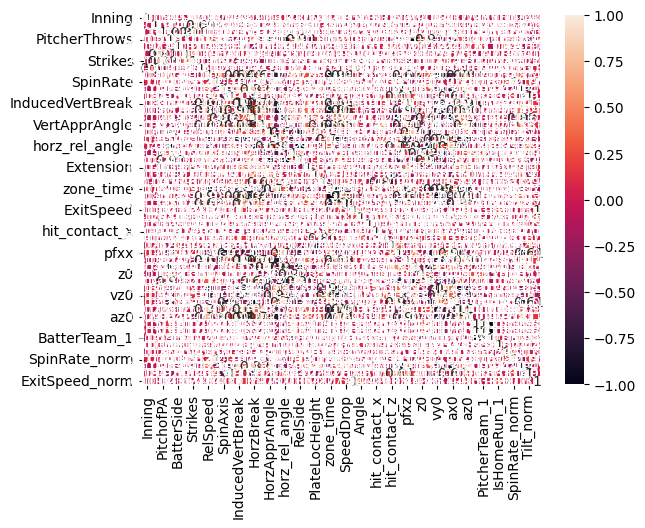

In [63]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Neural Nets ()

### SVM

## Outcome